# **Abstract:**
## data we aim to collect is from images-dataset called AFLW2000, this notebook is to explore the dataset and extract the data needed to train the model.




---


### import important libraries

In [1]:
%%capture
!pip install mediapipe

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os,cv2,math,glob,random
import scipy.io as sio
from math import cos, sin
from pathlib import Path
import pandas as pd
import mediapipe
import warnings
warnings.filterwarnings('ignore')
from google.colab.patches import cv2_imshow

### loading & exploring the dataset

In [3]:
# Loading AFLW2000 Data

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
folder_path = '/content/drive/MyDrive/AFLW2000/'

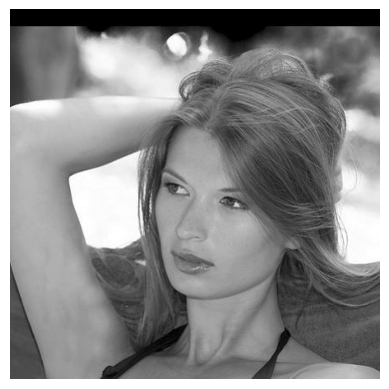

In [5]:
random_file = 'image00797'

image = cv2.imread(folder_path +random_file+'.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.axis('off')
plt.imshow(image)

### extract the facial landmarks using mediapipe

face_mesh extract 468 face landmarks, based on this photo. Nose index = 1, so nose point position can be easily extracted for later normlization and centralize the axises.

nose position:  (0.4719025194644928, 0.6018232107162476)
number of points: 468
distance x: 0.04508817195892334
distance y: 0.18845075368881226
(450, 450, 3)


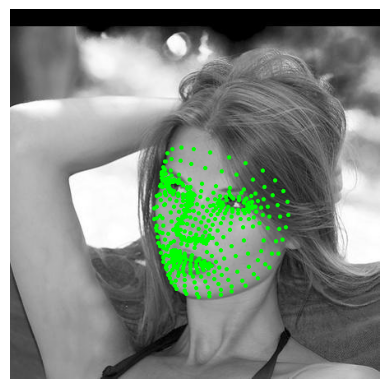

In [6]:
X = []
Y = []

faceModule = mediapipe.solutions.face_mesh

# loading image and its correspinding mat file
image = cv2.imread(folder_path +random_file+'.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
with faceModule.FaceMesh(static_image_mode=True) as faces:

    # processing the face to extract the landmark points for x,y
    results = faces.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    if results.multi_face_landmarks != None:

      # looping over the faces in the image
      for face in results.multi_face_landmarks:
          for landmark in face.landmark:
              x = landmark.x
              y = landmark.y

              # note: the x and y values are scaled to the their width and height so we will get back their actual value in the image
              shape = image.shape
              relative_x = int(x * shape[1])
              relative_y = int(y * shape[0])

              cv2.circle(image, (relative_x, relative_y), radius=1, color=(0, 255, 0), thickness=2)
              X.append(relative_x)
              Y.append(relative_y)
          for idx, lm in enumerate(results.multi_face_landmarks[0].landmark):
              if idx ==4:
                nose_x = lm.x
                nose_y = lm.y

              if idx == 0:
                lower_x = lm.x
                lower_y = lm.y

              if idx == 9:
                upper_x = lm.x
                upper_y = lm.y

distance_x = abs(upper_x - lower_x)
distance_y = abs(upper_y - lower_y)

print('nose position: ', (nose_x, nose_y))
print('number of points:', len(X))
print('distance x:', distance_x)
print('distance y:', distance_y)

print(image.shape)
plt.axis('off')
plt.imshow(image)

### extract image labels (yaw - pitch - roll) and draw the axises


In [7]:
def draw_axis(img, pitch,yaw,roll, center_point, size = 100):

    yaw = -yaw

    if center_point is None:
        height, width = img.shape[:2]
        center_point = (width / 2, height / 2)

    tdx, tdy = center_point

    # X-Axis pointing to right. drawn in red
    x1 = size * (cos(yaw) * cos(roll)) + tdx
    y1 = size * (cos(pitch) * sin(roll) + cos(roll) * sin(pitch) * sin(yaw)) + tdy

    # Y-Axis | drawn in green
    #        v
    x2 = size * (-cos(yaw) * sin(roll)) + tdx
    y2 = size * (cos(pitch) * cos(roll) - sin(pitch) * sin(yaw) * sin(roll)) + tdy

    # Z-Axis (out of the screen) drawn in blue
    x3 = size * (sin(yaw)) + tdx
    y3 = size * (-cos(yaw) * sin(pitch)) + tdy

    cv2.line(img, (int(tdx), int(tdy)), (int(x1),int(y1)),(0,0,255),3)
    cv2.line(img, (int(tdx), int(tdy)), (int(x2),int(y2)),(0,255,0),3)
    cv2.line(img, (int(tdx), int(tdy)), (int(x3),int(y3)),(255,0,0),2)

    return img

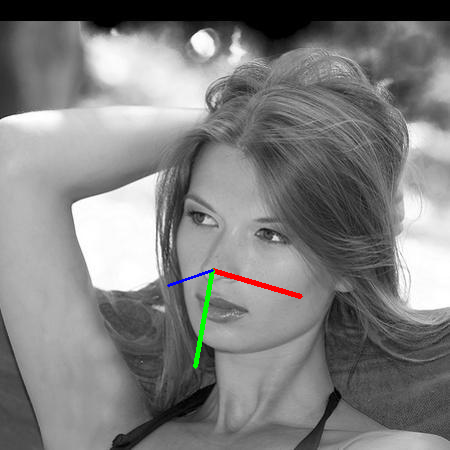

In [8]:
image = cv2.imread(folder_path +random_file+'.jpg')

# loading the mat file to extract the 3 angels of the face (pitch,yaw,roll)
mat_file = sio.loadmat(folder_path +random_file+'.mat')

# extracting the labels 3 angels
pose_para = mat_file["Pose_Para"][0][:3]
pitch = pose_para[0]
yaw = pose_para[1]
roll = pose_para[2]

h, w, c = image.shape
center_point = (nose_x * w, nose_y * h)

cv2_imshow(draw_axis(image, pitch, yaw, roll, center_point))

each image has 468 point and each point has x-axis and y-axis, so the dataset should consist of:

*   2000 observations (images)
*   936 features (468 x-points, 468 y-points)
*   3 labels





### Extract the dataset (normalized)

In [9]:
# Create lists to store data
all_data = []

faceModule = mediapipe.solutions.face_mesh

# Loop through all image files in the folder
for image_file in os.listdir(folder_path):
    if image_file.endswith('.jpg'):
        # Load the image
        image_path = os.path.join(folder_path, image_file)
        image = cv2.imread(image_path)

        # Process the face to extract landmark points
        with faceModule.FaceMesh(static_image_mode=True) as faces:
            results = faces.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
            data = []

            if results.multi_face_landmarks is not None:

              #extract nose point for points refrence (centralization), and axis drawing
              #extract 2 other points for shaping the face size within the same range
              for idx, lm in enumerate(results.multi_face_landmarks[0].landmark):
                if idx == 4:
                  nose_x = lm.x
                  nose_y = lm.y

                if idx == 291:
                  lower_x = lm.x
                  lower_y = lm.y

                if idx == 33:
                  upper_x = lm.x
                  upper_y = lm.y

              distance_x = upper_x - lower_x
              distance_y = upper_y - lower_y
              distance = np.sqrt(distance_x**2 + distance_y**2)

              #filling the list with extracted facial landmarks
              for face in results.multi_face_landmarks:
                  for landmark in face.landmark:
                      x = (landmark.x - nose_x) / distance
                      y = (landmark.y - nose_y) / distance
                      shape = image.shape
                      X = int(x * shape[1])
                      Y = int(y * shape[0])
                      data.extend([X, Y])

             #fill with 'null' if no points detected
            else:
                data = ['null'] * 936

            # Load the corresponding mat file to extract pitch, yaw, roll
            mat_file_path = os.path.join(folder_path, image_file.replace('.jpg', '.mat'))
            mat_file = sio.loadmat(mat_file_path)
            pose_para = mat_file["Pose_Para"][0][:3]
            pitch = pose_para[0]
            yaw = pose_para[1]
            roll = pose_para[2]

            data.extend([pitch, yaw, roll])
            all_data.append(data)

# Create a dataframe
cols = []
for num in range(0, 468):
  for dim in ('x_', 'y_'):
    cols.append(f'{dim}{num}')
cols.extend(['pitch', 'yaw', 'roll'])

df = pd.DataFrame(all_data, columns=cols)

In [11]:
df

,x_0,y_0,x_1,y_1,x_2,y_2,x_3,y_3,x_4,y_4,...,y_464,x_465,y_465,x_466,y_466,x_467,y_467,pitch,yaw,roll
0,null,null,null,null,null,null,null,null,null,null,...,null,null,null,null,null,null,null,-0.075096,-1.115535,0.202319
1,-121,139,-12,37,-109,70,-61,-86,0,0,...,-197,-90,-186,-42,-228,-37,-253,-1.108159,-1.443685,1.129171
2,52,100,7,24,43,35,-8,-75,0,0,...,-182,92,-169,275,-223,292,-244,-0.373085,0.293578,-0.125011
3,0,79,0,23,0,29,-24,-77,0,0,...,-189,46,-176,212,-244,223,-254,-0.474087,-0.040907,0.019801
4,-37,94,-4,29,-23,48,-26,-76,0,0,...,-147,26,-141,165,-161,177,-164,-0.116700,-0.233745,0.095809
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,-77,129,-9,31,-66,56,-45,-79,0,0,...,-182,-38,-171,48,-224,55,-238,-0.266459,-0.722653,0.219750
1996,7,105,-1,29,7,48,-11,-77,0,0,...,-158,81,-151,261,-180,275,-190,-0.161717,0.085792,0.027202
1997,52,114,2,30,43,59,6,-65,0,0,...,-134,119,-129,300,-158,322,-168,-0.046365,0.580349,-0.023616
1998,-6,134,2,27,-12,70,-38,-50,0,0,...,-114,0,-109,115,-144,125,-164,-0.948136,-1.241852,1.234426


In [12]:
df = df[df['x_0'] != 'null']

In [13]:
df.shape

(1853, 939)

In [14]:
# Save dataframe to CSV

df.to_csv('/content/face_landmarks.csv', index=False)